In [1]:
import numpy as np
import pandas as pd
import timeit
import time
import matplotlib.pyplot as plt
import random
import scipy.io

In [2]:
import tensorflow.compat.v1 as tf
from tqdm import tqdm
import timeit 
tf.disable_v2_behavior()

2023-08-15 21:14:58.461859: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-08-15 21:14:58.793283: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-15 21:14:59.608271: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-15 21:14:59.609916: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-15 21:15:03.501150: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
# First, I obtain training data by solving the Predator-Prey problem using MATLAB
# I save the z1, z2 I obtained as an MAT file

####################################################################################
# Load Data

data = scipy.io.loadmat('./pred_prey.mat')

In [4]:
z1z2_data = data['z']   # N x 2
t_data = data['t']   # N x 1

print(z1z2_data.shape)
print(t_data.shape)


(3000, 2)
(3000, 1)


In [5]:
z1z2_data = data['z']   # N x 2
t_data = data['t']   # N x 1

z1_data = z1z2_data[:,0].flatten()[:,None] 
z2_data = z1z2_data[:,1].flatten()[:,None] 
t_data = t_data.flatten()[:,None] 

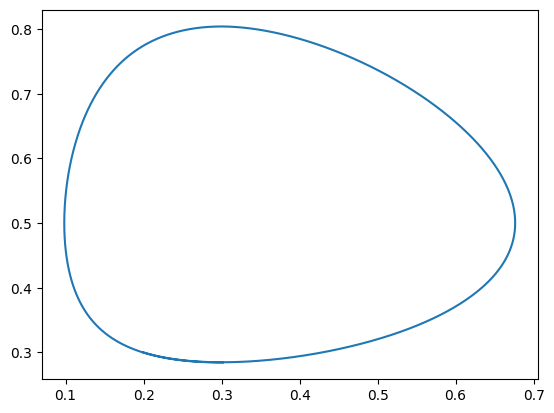

In [6]:
plt.plot(z1_data,z2_data,"-")
plt.show()

In [7]:
class PINN:
    # Initialize the class
    def __init__(self, t, z1, z2, layers, layers1, layers2, layers3, layers4):
        
        self.lb = t.min(0)
        self.ub = t.max(0)
        
        self.t = t
        
        self.z1 = z1
        self.z2 = z2
        
        self.layers = layers
        self.layers1 = layers1
        self.layers2 = layers2
        self.layers3 = layers3
        self.layers4 = layers4
        
        self.weights, self.biases = self.initialize_NN(layers)
        self.weights1, self.biases1 = self.initialize_NN(layers1)
        self.weights2, self.biases2 = self.initialize_NN(layers2)
        self.weights3, self.biases3 = self.initialize_NN(layers3)
        self.weights4, self.biases4 = self.initialize_NN(layers4)
        
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        

        
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.z1_tf = tf.placeholder(tf.float32, shape=[None, self.z1.shape[1]])
        self.z2_tf = tf.placeholder(tf.float32, shape=[None, self.z2.shape[1]])               
        
        self.z1_pred, self.z2_pred = self.net_ASIR(self.t_tf)
        self.aa_pred = self.aa_net(self.t_tf)
        self.bb_pred = self.bb_net(self.t_tf)
        self.cc_pred = self.cc_net(self.t_tf)
        self.dd_pred = self.dd_net(self.t_tf)
        
        self.l1, self.l2 = self.net_l(self.t_tf)
        
        self.loss = tf.reduce_sum(tf.square(self.z1_tf - self.z1_pred)) + \
                    tf.reduce_sum(tf.square(self.z2_tf - self.z2_pred)) + \
                    tf.reduce_sum(tf.square(self.l1)) + \
                    tf.reduce_sum(tf.square(self.l2))
        
        self.optimizer = tf.train.AdamOptimizer(1e-3)
        self.train_op = self.optimizer.minimize(self.loss)
        self.loss_log = []
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, t, layers, weights, biases):
        num_layers = len(layers)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.sigmoid(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def neural_net1(self, t, layers1, weights1, biases1):
        num_layers = len(layers1)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights1[l]
            b = biases1[l]
            H = tf.sigmoid(tf.add(tf.matmul(H, W), b))
        W = weights1[-1]
        b = biases1[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def neural_net2(self, t, layers2, weights2, biases2):
        num_layers = len(layers2)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights2[l]
            b = biases2[l]
            H = tf.sigmoid(tf.add(tf.matmul(H, W), b))
        W = weights2[-1]
        b = biases2[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def neural_net3(self, t, layers3, weights3, biases3):
        num_layers = len(layers3)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights3[l]
            b = biases3[l]
            H = tf.sigmoid(tf.add(tf.matmul(H, W), b))
        W = weights3[-1]
        b = biases3[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    def neural_net4(self, t, layers4, weights4, biases4):
        num_layers = len(layers4)
        
        H = 2.0*(t - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights4[l]
            b = biases4[l]
            H = tf.sigmoid(tf.add(tf.matmul(H, W), b))
        W = weights4[-1]
        b = biases4[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
    
    
    def net_ASIR(self, t):
        ASIR = self.neural_net(t, self.layers, self.weights, self.biases)
        z1 = ASIR[:,0:1]
        z2 = ASIR[:,1:2]
        
        return z1, z2
    
    def aa_net(self,t):
        aa = self.neural_net1(t, self.layers1, self.weights1, self.biases1)
        alp = aa
        return alp
    
    def bb_net(self,t):
        bb = self.neural_net2(t, self.layers2, self.weights2, self.biases2)
        blp = bb
        return blp
    
    def cc_net(self,t):
        cc = self.neural_net3(t, self.layers3, self.weights3, self.biases3)
        clp = cc
        return clp
    
    def dd_net(self,t):
        dd = self.neural_net4(t, self.layers4, self.weights4, self.biases4)
        dlp = dd
        return dlp
        
        
    def net_l(self, t):
        z1, z2 = self.net_ASIR(t)
        aa = self.aa_net(t)
        bb = self.bb_net(t)
        cc = self.cc_net(t)
        dd = self.dd_net(t)
        
        z1_t = tf.gradients(z1, t)[0]
        z2_t = tf.gradients(z2, t)[0]
        
        l1 = z1_t - z1*aa + bb*z2*z1
        l2 = z2_t - z2*cc*z1 + dd*z2
        
        # l1 = z1_t - (z1*(aa - bb*z2))
        # l2 = z2_t - (z2*(cc*z1 - dd))
        
        return l1, l2 
        
        
    def train(self, nIter):
        tf_dict = {self.t_tf: self.t, self.z1_tf: self.z1, self.z2_tf: self.z2}
        start_time = timeit.default_timer()

        for it in tqdm(range(nIter)):
            self.sess.run(self.train_op, tf_dict)
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                self.loss_log.append(loss_value)
                start_time = timeit.default_timer()
                
    def predict(self, t_star):
        tf_dict = {self.t_tf: t_star}
        
        z1_star = self.sess.run(self.z1_pred, tf_dict)
        z2_star = self.sess.run(self.z2_pred, tf_dict)
        aa_star = self.sess.run(self.aa_pred, tf_dict)
        bb_star = self.sess.run(self.bb_pred, tf_dict)
        cc_star = self.sess.run(self.cc_pred, tf_dict)
        dd_star = self.sess.run(self.dd_pred, tf_dict)
        
        return z1_star, z2_star, aa_star, bb_star, cc_star, dd_star
        


In [8]:
niter = 50000  # number of Epochs
layers = [1, 64, 64, 64, 2]
layers1 = [1, 64, 64, 64, 1]
layers2 = [1, 64, 64, 64, 1]
layers3 = [1, 64, 64, 64, 1]
layers4 = [1, 64, 64, 64, 1]

model = PINN(t_data, z1_data, z2_data, layers, layers1, layers2, layers3, layers4)
model.train(niter)

Device mapping: no known devices.


2023-08-15 21:15:07.471893: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-15 21:15:08.229748: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-08-15 21:15:08.252051: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-15 21:15:08.252070: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-15 21:15:08.252074: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
2

truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/Assign: (Assign): /job:localhost/replica:0/task:0/device:CPU:0
Variable_1/read: (Identity): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
truncated_normal_1: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
Variable_2: (VariableV2): /job:localhost/replica:0/task:0/device:CPU:0
Var

100%|██████████| 50000/50000 [05:35<00:00, 149.06it/s]


In [9]:
# prediction
z1_pred, z2_pred, aa_pred, bb_pred, cc_pred, dd_pred = model.predict(t_data)

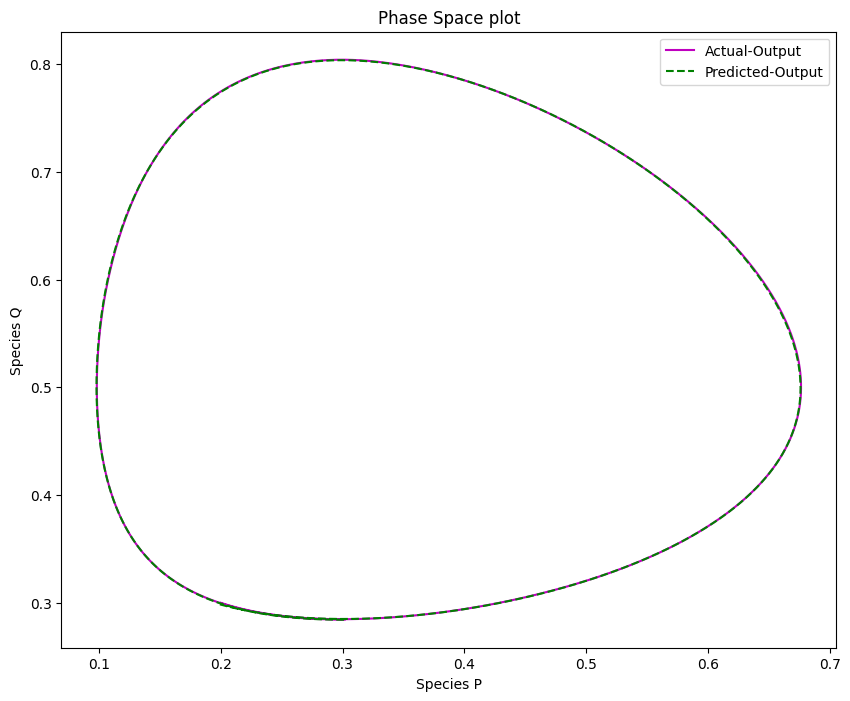

In [10]:
plt.rcParams['figure.figsize'] = [10,8]
plt.plot(z1_data,z2_data,'m')
plt.plot(z1_pred,z2_pred,'g--')
plt.legend(["Actual-Output", "Predicted-Output"])
plt.xlabel('Species P')
plt.ylabel("Species Q")
plt.title("Phase Space plot")
plt.show()

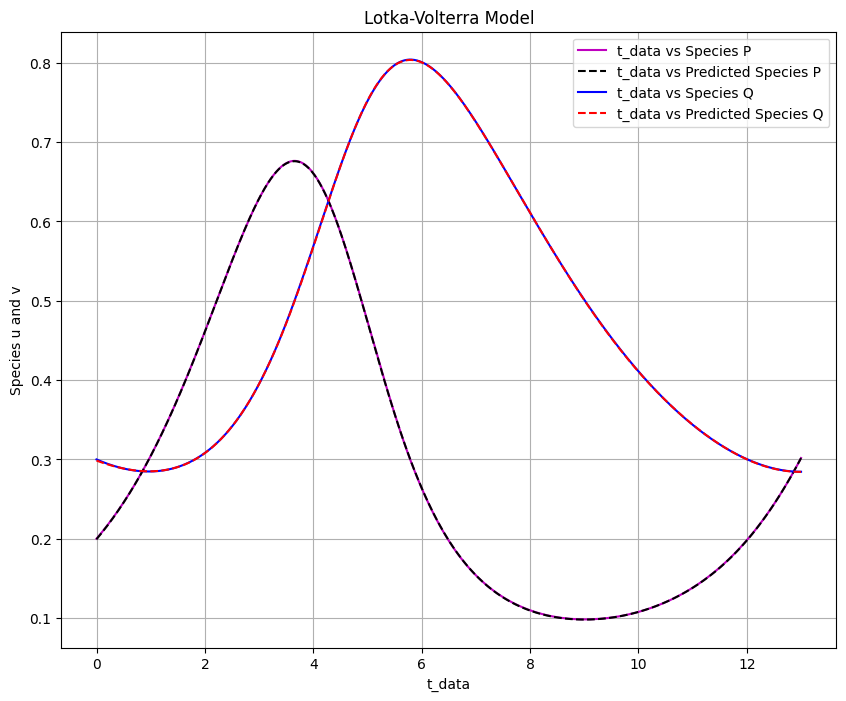

In [11]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(t_data,z1_data,'m')
#plt.plot(t_data,z1_data,'o')
plt.plot(t_data,z1_pred,'k--')

plt.plot(t_data,z2_data,'b')
#plt.plot(t_data,z2_data,'o')
plt.plot(t_data,z2_pred,'r--')

plt.xlabel('t_data')
plt.ylabel("Species u and v")
plt.legend(["t_data vs Species P","t_data vs Predicted Species P", "t_data vs Species Q",  "t_data vs Predicted Species Q"])
plt.title("Lotka-Volterra Model")
plt.grid(True)
plt.show()

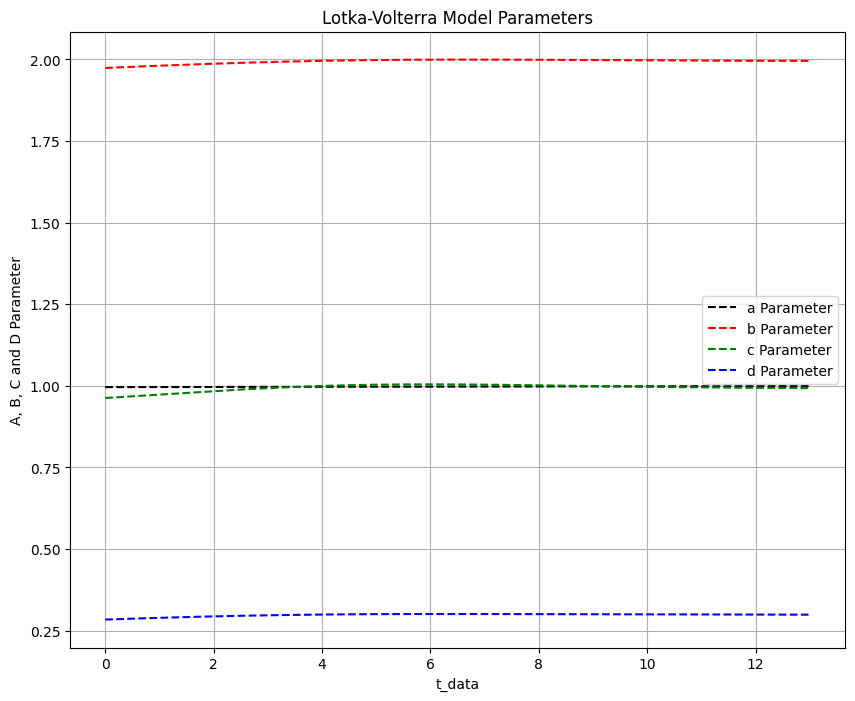

In [12]:
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(t_data,aa_pred,'k--')
plt.plot(t_data,bb_pred,'r--')
plt.plot(t_data,cc_pred,'g--')
plt.plot(t_data,dd_pred,'b--')

plt.xlabel('t_data')
plt.ylabel("A, B, C and D Parameter")
plt.legend(["a Parameter", "b Parameter", "c Parameter", "d Parameter"])
plt.title("Lotka-Volterra Model Parameters")
plt.grid(True) 
plt.show()

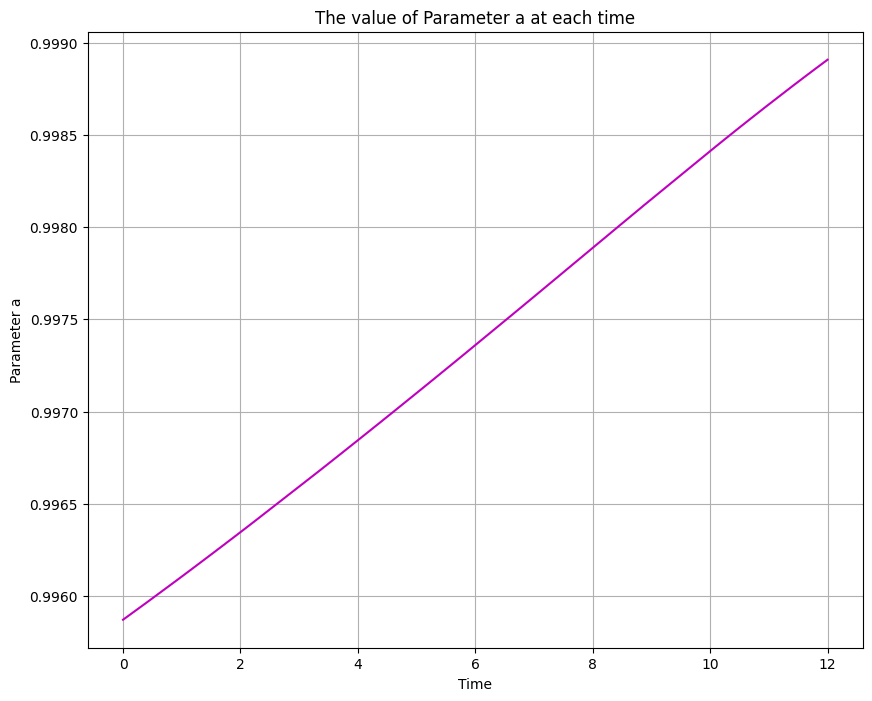

In [13]:
start_range = 0.0
end_range = 12.0

# Find the indices that correspond to the specified range
indices = [i for i, t in enumerate(t_data) if start_range <= t <= end_range]

# Extract the corresponding t_data and aa_pred values
t_data_filtered = [t_data[i] for i in indices]
aa_pred_filtered = [aa_pred[i] for i in indices]

# Plot the filtered data
plt.plot(t_data_filtered, aa_pred_filtered, "m")
plt.xlabel('Time')
plt.ylabel('Parameter a')
plt.grid(True)
plt.title('The value of Parameter a at each time')
plt.show()

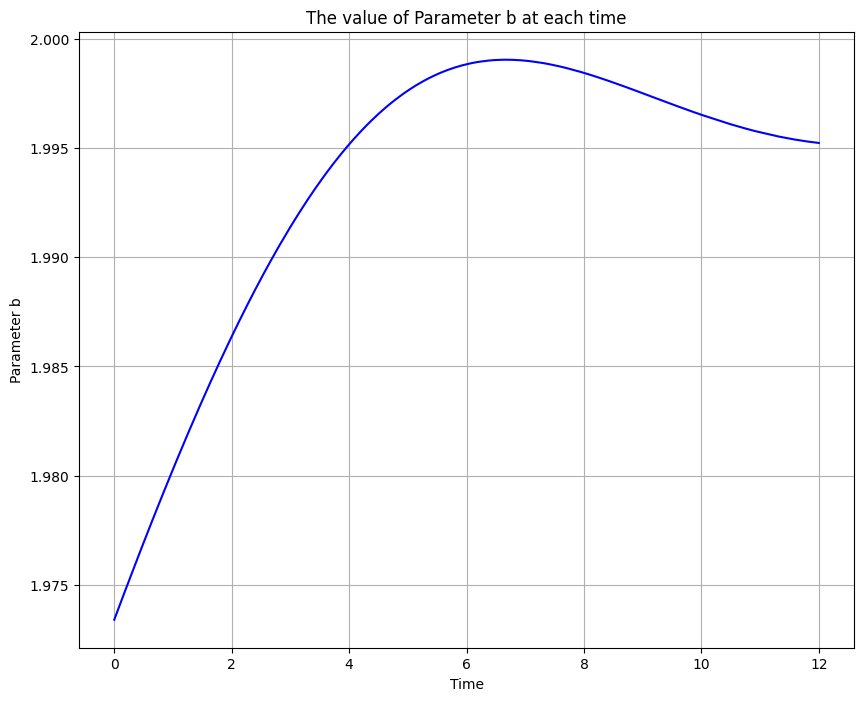

In [14]:
start_range = 0.0
end_range = 12.0

# Find the indices that correspond to the specified range
indices = [i for i, t in enumerate(t_data) if start_range <= t <= end_range]

# Extract the corresponding t_data and aa_pred values
t_data_filtered = [t_data[i] for i in indices]
bb_pred_filtered = [bb_pred[i] for i in indices]

# Plot the filtered data
plt.plot(t_data_filtered, bb_pred_filtered, "b")
plt.xlabel('Time')
plt.ylabel('Parameter b')
plt.grid(True)
plt.title('The value of Parameter b at each time')
plt.show()

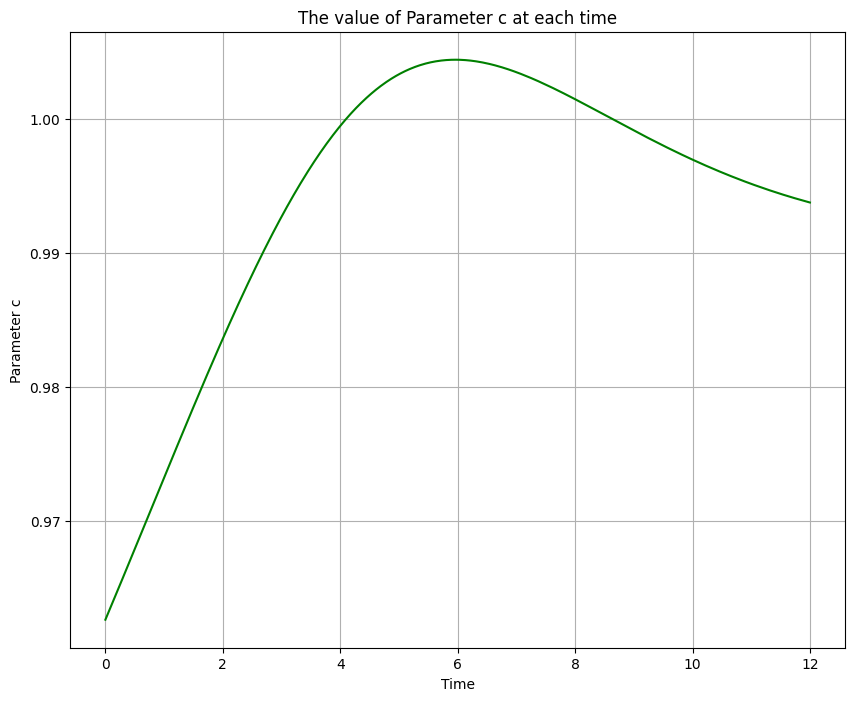

In [15]:
start_range = 0.0
end_range = 12.0

# Find the indices that correspond to the specified range
indices = [i for i, t in enumerate(t_data) if start_range <= t <= end_range]

# Extract the corresponding t_data and aa_pred values
t_data_filtered = [t_data[i] for i in indices]
cc_pred_filtered = [cc_pred[i] for i in indices]

# Plot the filtered data
plt.plot(t_data_filtered, cc_pred_filtered, "g")
plt.xlabel('Time')
plt.ylabel('Parameter c')
plt.grid(True)
plt.title('The value of Parameter c at each time')
plt.show()

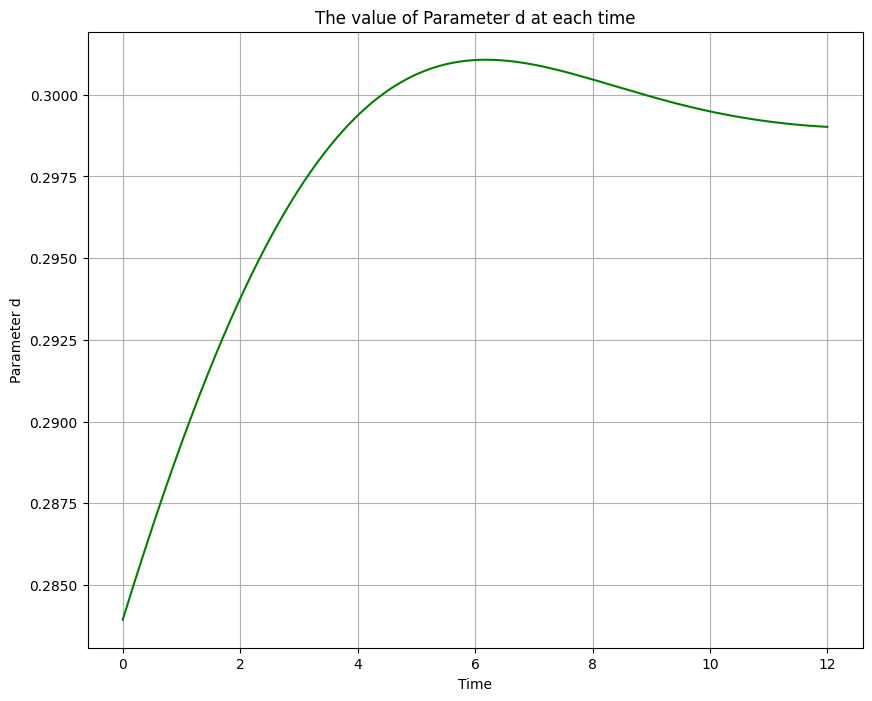

In [16]:
start_range = 0.0
end_range = 12.0

# Find the indices that correspond to the specified range
indices = [i for i, t in enumerate(t_data) if start_range <= t <= end_range]

# Extract the corresponding t_data and aa_pred values
t_data_filtered = [t_data[i] for i in indices]
dd_pred_filtered = [dd_pred[i] for i in indices]

# Plot the filtered data
plt.plot(t_data_filtered, dd_pred_filtered, "g")
plt.xlabel('Time')
plt.ylabel('Parameter d')
plt.grid(True)
plt.title('The value of Parameter d at each time')
plt.show()

In [17]:
import numpy as np

aa = 1  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(aa - i) for i in aa_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_preda = aa_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_preda} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [0.99913603] at time step 2999, which occurred at [13.].


In [18]:
import numpy as np

bb = 2  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(bb - i) for i in bb_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_predb = bb_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_predb} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [1.9990387] at time step 1537, which occurred at [6.66255418].


In [19]:
import numpy as np

cc = 1  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(cc - i) for i in cc_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_predc = cc_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]

# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_predc} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [1.000002] at time step 1989, which occurred at [8.62187396].


In [20]:
import numpy as np

dd = 0.3  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(dd - i) for i in dd_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_predd = dd_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]

# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_predd} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [0.3] at time step 1019, which occurred at [4.41713905].


Loss: 0.002255237


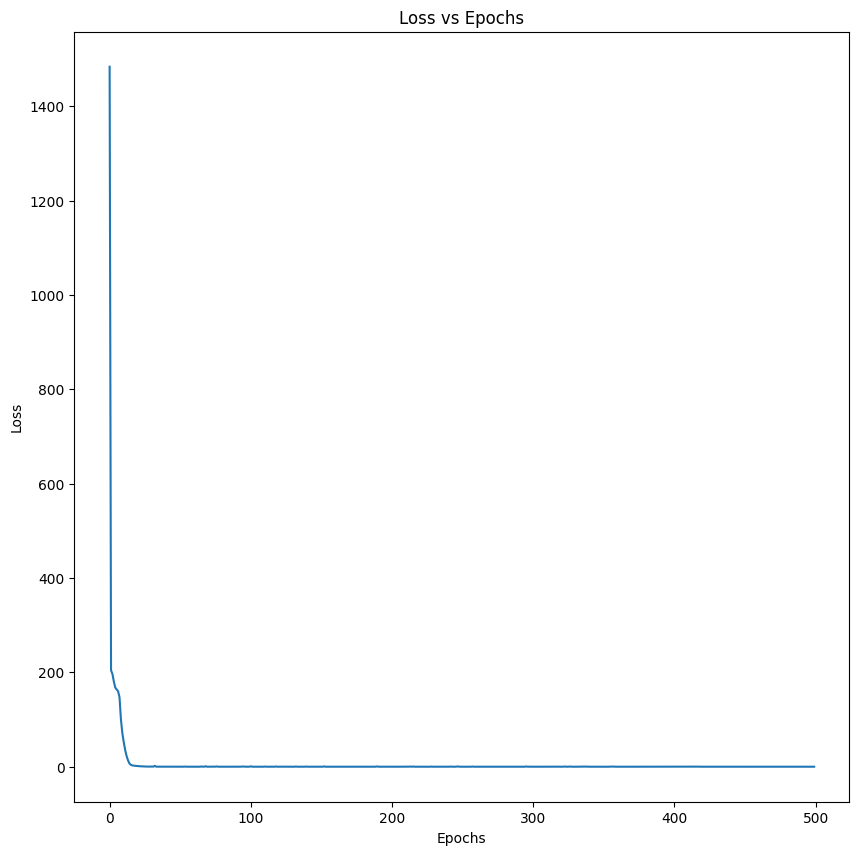

R^2 score for z1: 0.999997646126026
R^2 score for z2: 0.9999967707468476
MSE for z1: 8.524375767989529e-08
MSE for z2: 1.0659799758974317e-07
MAE for z1: 0.00023451726668903173
MAE for z2: 0.00024140625603187127
EVS for z1: 0.9999982893176402
EVS for z2: 0.9999975279021219
RMSE for z1: 0.00029196533643550103
RMSE for z2: 0.0003264934878213395


In [21]:
# calculate the loss
loss = model.sess.run(model.loss, {model.t_tf: t_data, model.z1_tf: z1_data, model.z2_tf: z2_data})
print("Loss:", loss)

# plot the loss
plt.rcParams['figure.figsize'] = [10, 10]
plt.plot(model.loss_log)
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.title("Loss vs Epochs")
plt.show()

# calculate the R^2 score
from sklearn.metrics import r2_score
r2_z1 = r2_score(z1_data, z1_pred)
r2_z2 = r2_score(z2_data, z2_pred)
print("R^2 score for z1:", r2_z1)
print("R^2 score for z2:", r2_z2)

# calculate the mean squared error
from sklearn.metrics import mean_squared_error
mse_z1 = mean_squared_error(z1_data, z1_pred)
mse_z2 = mean_squared_error(z2_data, z2_pred)
print("MSE for z1:", mse_z1)
print("MSE for z2:", mse_z2)

# calculate the mean absolute error
from sklearn.metrics import mean_absolute_error
mae_z1 = mean_absolute_error(z1_data, z1_pred)
mae_z2 = mean_absolute_error(z2_data, z2_pred)
print("MAE for z1:", mae_z1)
print("MAE for z2:", mae_z2)


# calculate the Explained Variance Score
from sklearn.metrics import explained_variance_score
evs_z1 = explained_variance_score(z1_data, z1_pred)
evs_z2 = explained_variance_score(z2_data, z2_pred)
print("EVS for z1:", evs_z1)
print("EVS for z2:", evs_z2)

# calculate the root mean squared error
from sklearn.metrics import mean_squared_error
rmse_z1 = mean_squared_error(z1_data, z1_pred, squared=False)
rmse_z2 = mean_squared_error(z2_data, z2_pred, squared=False)
print("RMSE for z1:", rmse_z1)
print("RMSE for z2:", rmse_z2)


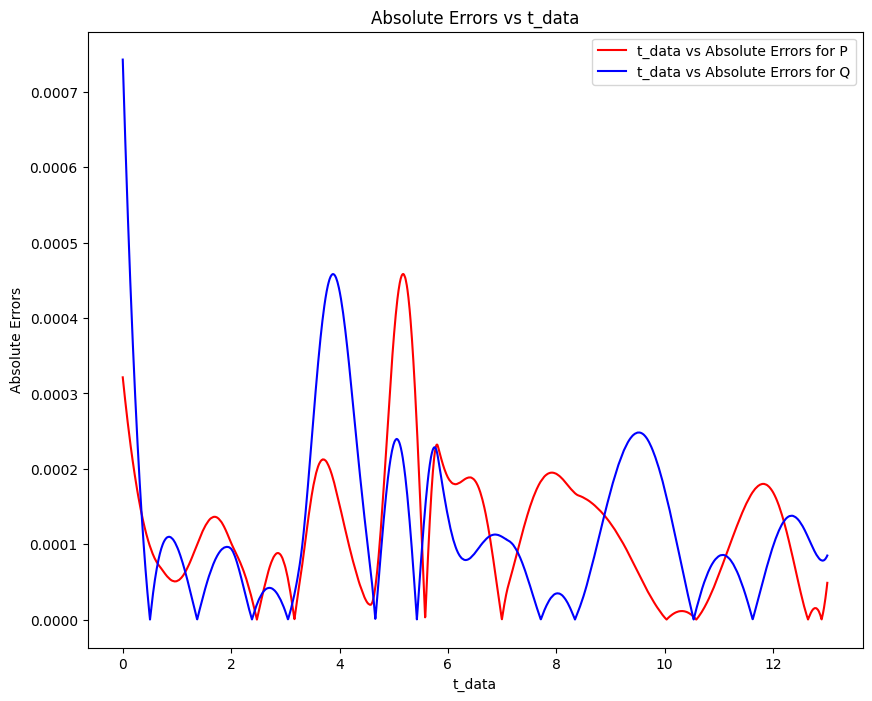

In [22]:
# plot the absolute errors between the target and the predictions and let it all start at zero
plt.rcParams['figure.figsize'] = [10, 8]
plt.plot(t_data, 1/2*(abs(z1_data-z1_pred)), 'r')
plt.plot(t_data, 1/2*(abs(z2_data-z2_pred)), 'b')
plt.xlabel('t_data')
plt.ylabel("Absolute Errors")
plt.legend(["t_data vs Absolute Errors for P", "t_data vs Absolute Errors for Q"])
plt.title("Absolute Errors vs t_data")
plt.show()

____

In [23]:
niter = 50000  # number of Epochs
layers = [1, 20,  2]
layers1 = [1, 20,  1]
layers2 = [1, 20,  1]
layers3 = [1, 20,  1]
layers4 = [1, 20,  1]

model = PINN(t_data, z1_data, z2_data, layers, layers1, layers2, layers3, layers4)
model.train(niter)

Device mapping: no known devices.


2023-08-15 21:20:47.763571: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-08-15 21:20:48.421490: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/TruncatedNormal: (TruncatedNormal): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-15 21:20:48.421537: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal/mul: (Mul): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-15 21:20:48.421542: I tensorflow/core/common_runtime/placer.cc:114] truncated_normal: (AddV2): /job:localhost/replica:0/task:0/device:CPU:0
2023-08-15 21:20:48.421546: I tensorflow/core/common_runtime/placer.cc:114] Variable: (VariableV2): /job:localhost/replica:0/task:0/de

:0/task:0/device:CPU:0
Variable_31/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_32/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_32/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_33/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_33/Adam_1/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_34/Adam/Initializer/zeros/shape_as_tensor: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_34/Adam/Initializer/zeros/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_34/Adam_1/Initializer/zeros/shape_as_tensor: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_34/Adam_1/Initializer/zeros/Const: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_35/Adam/Initializer/zeros: (Const): /job:localhost/replica:0/task:0/device:CPU:0
Variable_35/Adam_1/Init

100%|██████████| 50000/50000 [01:02<00:00, 804.05it/s]


In [24]:
# prediction
z1_pred, z2_pred, aa_pred, bb_pred, cc_pred, dd_pred = model.predict(t_data)

In [25]:
import numpy as np

aa = 1  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(aa - i) for i in aa_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_pred = aa_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_pred} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [0.99987566] at time step 619, which occurred at [2.68322774].


In [26]:
import numpy as np

bb = 2  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(bb - i) for i in bb_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_pred = bb_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]


# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_pred} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [1.9997712] at time step 603, which occurred at [2.61387129].


In [27]:
import numpy as np

cc = 1  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(cc - i) for i in cc_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_pred = cc_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]

# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_pred} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [0.9998694] at time step 2608, which occurred at [11.3051017].


In [28]:
import numpy as np

dd = 0.3  # initial parameter

# Using list comprehension and abs() function to calculate absolute differences
diffs = [abs(dd - i) for i in dd_pred]

# Using np.argmin() to find the index of smallest difference
index_min_diff = np.argmin(diffs)

# Getting the best predicted value
best_pred = dd_pred[index_min_diff]

# Getting the time of the best prediction
best_pred_time = t_data[index_min_diff]

# Print the best predicted value, its time step, and the actual time
print(f"The best predicted value is {best_pred} at time step {index_min_diff}, which occurred at {best_pred_time}.")

The best predicted value is [0.30000493] at time step 2576, which occurred at [11.1663888].


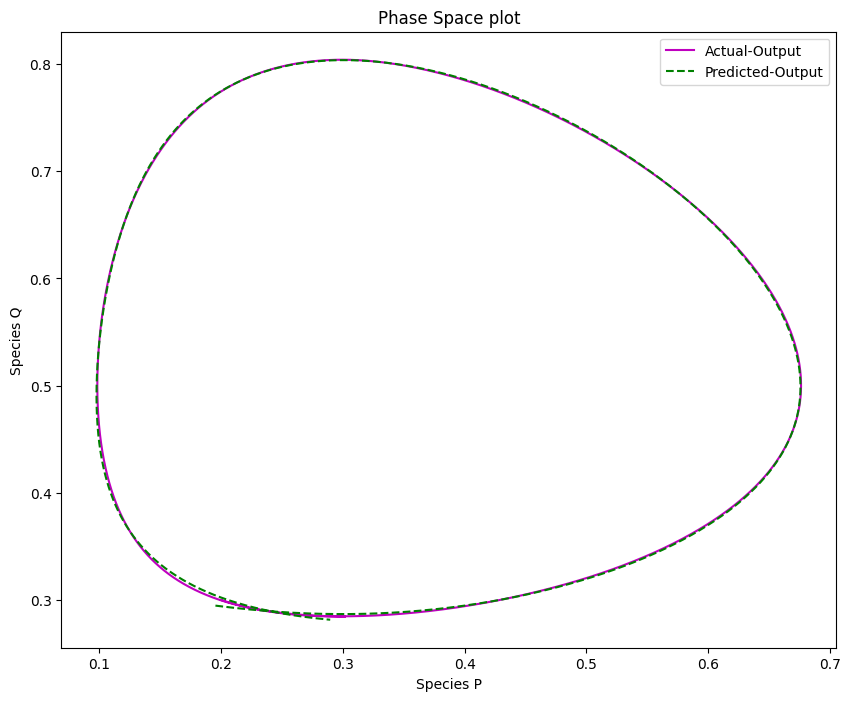

In [29]:
plt.rcParams['figure.figsize'] = [10,8]
plt.plot(z1_data,z2_data,'m')
plt.plot(z1_pred,z2_pred,'g--')
plt.legend(["Actual-Output", "Predicted-Output"])
plt.xlabel('Species P')
plt.ylabel("Species Q")
plt.title("Phase Space plot")
plt.show()